## Random Forest and Extra Trees

Random Forest algorithm is an <b>ensemble of decision trees</b>, which can be used to solve both regression and classification tasks.

Random forest handles both <b>row sampling and feature sampling</b>, compared to standard bagging classifiers.

In random forest, dataset that is passed to random forest model internally uses 2/3 of the data for every decision tree (known as <b>in-bag error</b>) and remaining 1/3 of the data is used for model evaluation on every decision tree (known as <b>out-of-bag error</b>).

<img src="https://miro.medium.com/max/700/1*JX-7eSfyvxEiAoHnulaiLQ.png" width="600">

Extra Trees behaviour similar to Random Forest, but an additional source of randomness is introduced. Instead of using most discriminative thresholds from random subset of candidate features, <b>thresholds are also selected at random for every candidate feature</b>. This additional source of randomness further reduces variance in model, in exchange for slightly higher model bias.

<b>Assumptions of Random Forest:</b> No specific formal distributions required

<b>Requirement of feature scaling: No</b>

<b>Robust to outliers: Yes</b>

<b>Is multicollinearity an issue?: No</b>

<b>Advantages of Random Forest:</b>
1. Robust to outliers.
2. Works well for non-linear data.
3. Low risk of overfitting.
4. Runs efficiently on large datasets.
5. Feature importance can be determined
6. Model performance not impacted by missing values.

<b>Disadvantages of Random Forest:</b>
1. Slow training.
2. Biased when dealing with categorical variables, as feature selection technique is biased towards preferring variables with more categories.

<b>Time complexity of model training: O(n * log(n) * p * m)</b>

<b>Time complexity of model prediction: O(d*m)</b>

<b>Space complexity of model prediction: O(k*m)</b>

n - Number of training samples

p - Number of features

d - Maximum depth of tree

k - Number of nodes in tree

m - Number of decision trees

<b>Extra Notes</b>:
1. Bootstrapping in random forest reduces correlation between different trees, while creating more diversified trees for better generalization. Note that Random Forest enables bootstrapping option by default, while Extra Trees disable boostrapping option by default.
2. oob_score is an optional hyperparameter of performance evaluation from using bootstrapping, but not for true performance evaluation as it is only based on a selection of trees at random within a forest
3. n_estimators hyperparameter does not impact risk of model overfitting. Best suggested values are between 64 and 128.
4. Forest error rate depends on two factors:
- Correlation between different decision trees: Higher correlation results in higher forest error rate
- Strength of individual decision trees: Lower error rate of decision tree results in higher strength of decision tree, thus lower forest error rate

## Feature selection for Random Forest and Extra Trees

A special feature available in Random Forest and Extra Trees algorithm is feature selection. 

In scikit-learn, feature importance is computed based on <b>average of gini impurity index</b>. The higher the average of gini impurity index, the higher the importance of the feature in the model.

<b>Steps for computing feature importance in Random Forest/Extra Trees algorithm</b>:

1. Count the number of correct votes in original out-of-bag data for every decision tree.

2. Shuffle the order of values of given feature and count number of correct votes for every decision tree.

3. Subtract the count of votes of step 2 from step 1 for every decision tree. 

4. Feature importance for specific feature is the average value from step 3. The value is normalized by taking the standard deviation.

5. Larger score of feature importance indicates higher importance, as building model without its original values provide worse predictions.

<b>Note that impurity-based feature importances have two main flaws</b>:
1. Features that are identified important is based on training set, such that those features may not be suitable for making predictions in held-out dataset.
2. High-cardinality features are more favoured as being important features.

A more suitable alternative that doesn't have both flaws above is permutation-based feature importance, but at the expense of higher computational time.

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_wine
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor, ExtraTreesClassifier
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

More details related to Exploratory Data Analysis for both regression and classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Regression.ipynb and EDA_Classification.ipynb

## Random Forest and Extra Trees for regression

For regression tasks, features are divided into distinct and non-overlapping regions, where observations within the region are predicted as the average of target values.

<b>Important hyperparameters for RandomForestRegressor and ExtraTreesRegressor</b>:
- criterion: Function used to measure quality of split ('squared_error', 'friedman_mse', 'absolute_error', 'poisson')

- Post Pruning (Most preferable)
1. ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.

- Pre Pruning
1. max_depth: Maximum depth of decision tree
2. min_samples_split: Minimum number of samples required to split internal nodes
3. min_samples_leaf: Minimum number of samples required for leaf nodes
4. max_features: Number of features to consider when looking for splits

In [2]:
data = fetch_california_housing()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Median House Value ($100000)'

In [3]:
clf = DecisionTreeRegressor(random_state=120)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas

100%|██████████| 30/30 [01:42<00:00,  3.43s/it]


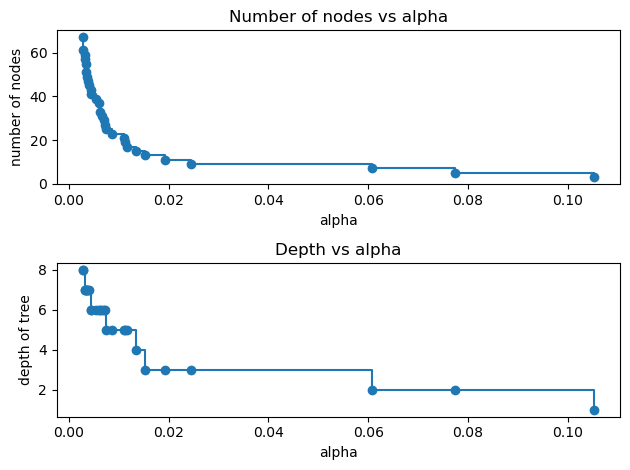

In [4]:
clfs = []
for ccp_alpha in tqdm(path.ccp_alphas[-30:]):
    clf = DecisionTreeRegressor(random_state=120, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[-30:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [5]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = KFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_rmse, test_rmse = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,
                               scoring= make_scorer(mean_squared_error, squared=False),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_rmse.append(search.best_score_)
        print(f'Validation RMSE for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_rmse.append(mean_squared_error(y_test,y_pred,squared=False))
        print(f'Test RMSE for fold {fold+1}:',mean_squared_error(y_test,y_pred,squared=False))
    print('----------------------')
    print('Average validation RMSE score:', np.mean(val_rmse))
    print('Average test RMSE score:', np.mean(test_rmse))

In [6]:
reg = RandomForestRegressor(random_state=120, n_jobs=-1)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__ccp_alpha'] = Categorical(ccp_alphas)
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 0.8010769542717266
Best hyperparameters for fold 1: OrderedDict([('regression__ccp_alpha', 0.0192990588977332)])
Test RMSE for fold 1: 0.7535332981474914
Validation RMSE for fold 2: 0.9174274585531013
Best hyperparameters for fold 2: OrderedDict([('regression__ccp_alpha', 0.10532587303314678)])
Test RMSE for fold 2: 0.9203484338762512
Validation RMSE for fold 3: 0.8686330993282704
Best hyperparameters for fold 3: OrderedDict([('regression__ccp_alpha', 0.07741133536083636)])
Test RMSE for fold 3: 0.8851808267316901
Validation RMSE for fold 4: 0.8111331170933143
Best hyperparameters for fold 4: OrderedDict([('regression__ccp_alpha', 0.02449386756476421)])
Test RMSE for fold 4: 0.7991566014791233
Validation RMSE for fold 5: 0.8496340731251231
Best hyperparameters for fold 5: OrderedDict([('regression__ccp_alpha', 0.06075385283365936)])
Test RMSE for fold 5: 0.8299686513638652
Validation RMSE for fold 6: 0.8714234270615743
Best hyperparameters for fold 6: Ordere

In [7]:
reg = ExtraTreesRegressor(random_state=120, n_jobs=-1)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__ccp_alpha'] = Categorical(ccp_alphas)
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 0.892003947898119
Best hyperparameters for fold 1: OrderedDict([('regression__ccp_alpha', 0.07741133536083636)])
Test RMSE for fold 1: 0.8463000641989594
Validation RMSE for fold 2: 0.907342876869689
Best hyperparameters for fold 2: OrderedDict([('regression__ccp_alpha', 0.10532587303314678)])
Test RMSE for fold 2: 0.901693981765409
Validation RMSE for fold 3: 0.8867492709221173
Best hyperparameters for fold 3: OrderedDict([('regression__ccp_alpha', 0.07741133536083636)])
Test RMSE for fold 3: 0.88862201777616
Validation RMSE for fold 4: 0.8707363372012873
Best hyperparameters for fold 4: OrderedDict([('regression__ccp_alpha', 0.06075385283365936)])
Test RMSE for fold 4: 0.8459945037309519
Validation RMSE for fold 5: 0.8222998185054038
Best hyperparameters for fold 5: OrderedDict([('regression__ccp_alpha', 0.0192990588977332)])
Test RMSE for fold 5: 0.810730839264552
Validation RMSE for fold 6: 0.8915521616814139
Best hyperparameters for fold 6: OrderedDict(

## Random Forest and Extra Trees for Classification

For classification tasks, features are divided into distinct and non-overlapping regions, where observations within the region are predicted as target class based on maximum votes.

<b>Important hyperparameters for RandomForestClassifier and ExtraTreesClassifier</b>:
- criterion: Function used to measure quality of split ('squared_error', 'friedman_mse', 'absolute_error', 'poisson')
- class_weight: Weights associated with target classes

- Post Pruning (Most preferable)
1. ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.

- Pre Pruning
1. max_depth: Maximum depth of decision tree
2. min_samples_split: Minimum number of samples required to split internal nodes
3. min_samples_leaf: Minimum number of samples required for leaf nodes
4. max_features: Number of features to consider when looking for splits

<b>Methods to handle imbalanced dataset for classification</b>:
1. Assign class weights to model
2. Resampling techniques (Oversampling/Combination of Oversampling and Undersampling - Less suitable for larger datasets due to high computation time)

In [8]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Wine_Class'

In [9]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

In [10]:
clf = DecisionTreeClassifier(random_state=120)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas

100%|██████████| 11/11 [00:00<00:00, 401.27it/s]


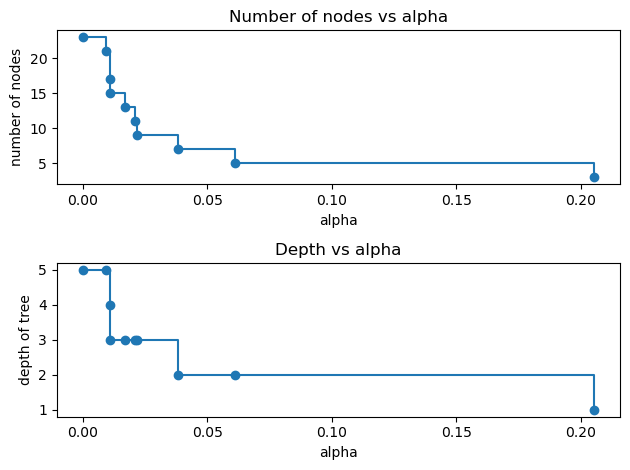

In [11]:
clfs = []
for ccp_alpha in tqdm(ccp_alphas):
    clf = DecisionTreeClassifier(random_state=120, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [13]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - RandomForestClassifier (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.9818686395822844
Best hyperparameters for fold 1: OrderedDict([('classification__ccp_alpha', 0.0), ('classification__class_weight', 'balanced_subsample')])
Test F1 score for fold 1: 1.0



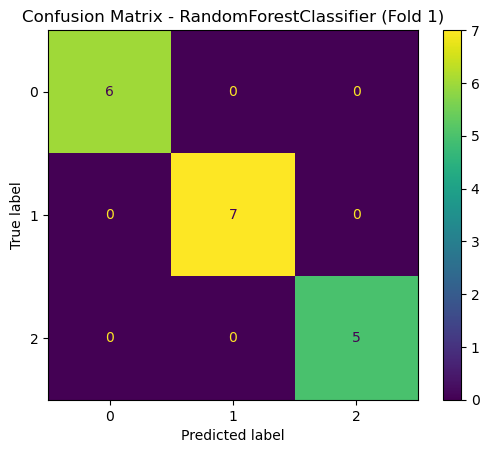


Validation F1 score for fold 2: 0.974860651201747
Best hyperparameters for fold 2: OrderedDict([('classification__ccp_alpha', 0.010955056179775272), ('classification__class_weight', None)])
Test F1 score for fold 2: 1.0



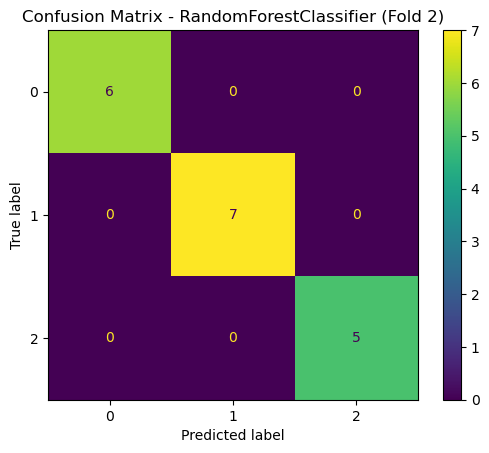


Validation F1 score for fold 3: 0.980845621679471
Best hyperparameters for fold 3: OrderedDict([('classification__ccp_alpha', 0.010955056179775272), ('classification__class_weight', 'balanced_subsample')])
Test F1 score for fold 3: 0.9487179487179486



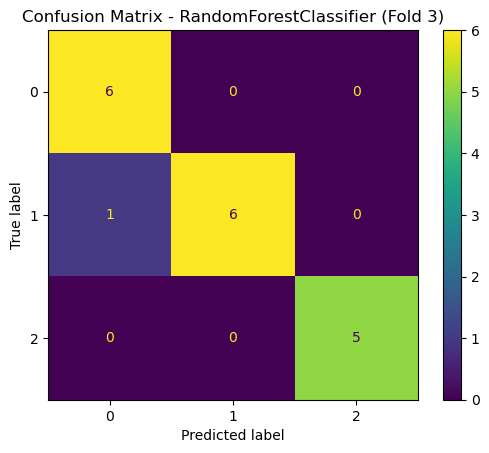


Validation F1 score for fold 4: 0.9810360897982381
Best hyperparameters for fold 4: OrderedDict([('classification__ccp_alpha', 0.009363295880149813), ('classification__class_weight', None)])
Test F1 score for fold 4: 1.0



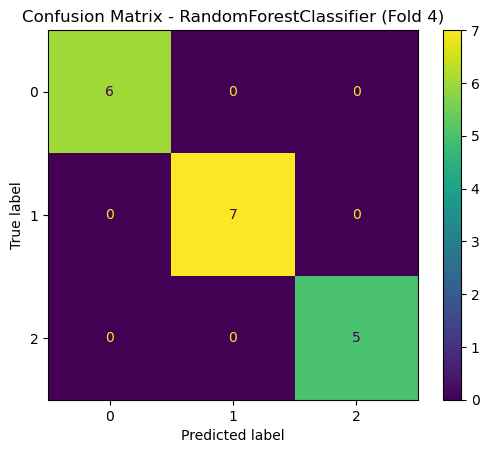


Validation F1 score for fold 5: 0.9692412180033664
Best hyperparameters for fold 5: OrderedDict([('classification__ccp_alpha', 0.0), ('classification__class_weight', 'balanced_subsample')])
Test F1 score for fold 5: 1.0



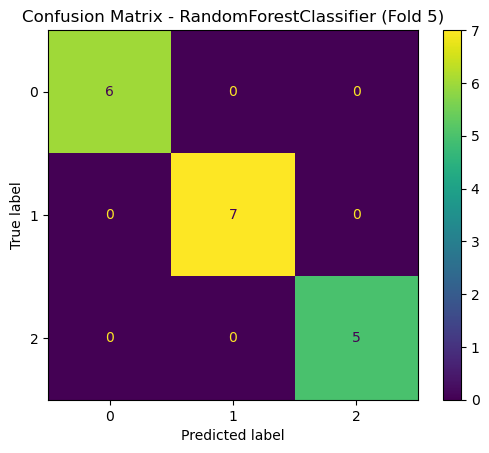


Validation F1 score for fold 6: 0.974860651201747
Best hyperparameters for fold 6: OrderedDict([('classification__ccp_alpha', 0.010955056179775272), ('classification__class_weight', 'balanced_subsample')])
Test F1 score for fold 6: 1.0



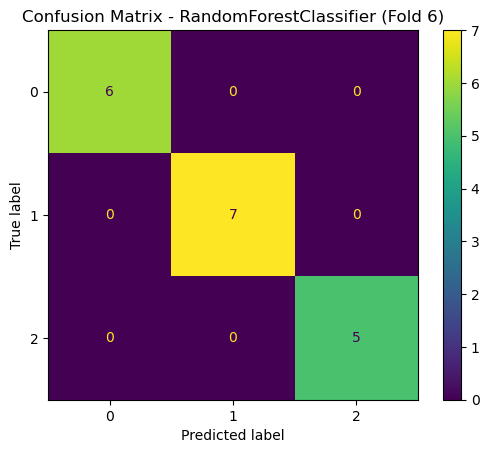


Validation F1 score for fold 7: 0.9750581820659445
Best hyperparameters for fold 7: OrderedDict([('classification__ccp_alpha', 0.010955056179775272), ('classification__class_weight', None)])
Test F1 score for fold 7: 1.0



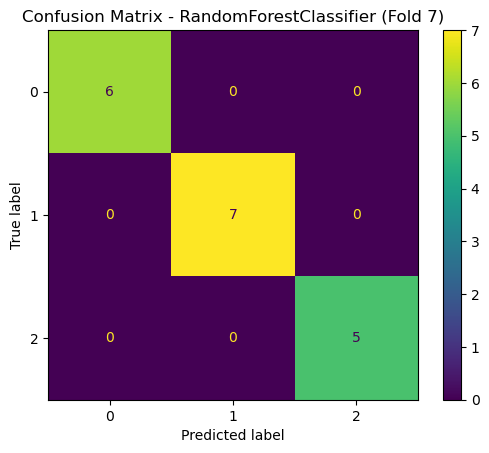


Validation F1 score for fold 8: 0.9688200922881229
Best hyperparameters for fold 8: OrderedDict([('classification__ccp_alpha', 0.0), ('classification__class_weight', None)])
Test F1 score for fold 8: 1.0



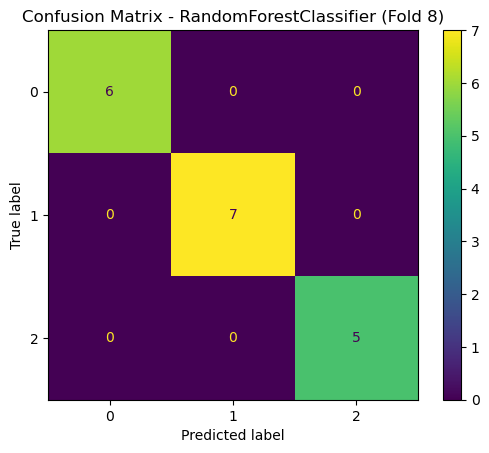


Validation F1 score for fold 9: 0.9702642359061796
Best hyperparameters for fold 9: OrderedDict([('classification__ccp_alpha', 0.010879258070269298), ('classification__class_weight', 'balanced')])
Test F1 score for fold 9: 0.9373219373219372



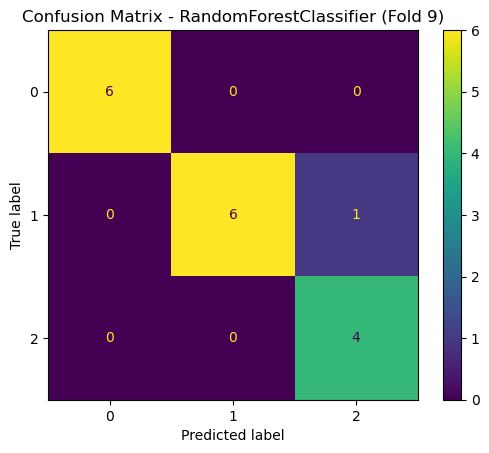


Validation F1 score for fold 10: 0.9762179442164186
Best hyperparameters for fold 10: OrderedDict([('classification__ccp_alpha', 0.009363295880149813), ('classification__class_weight', None)])
Test F1 score for fold 10: 0.9407407407407408



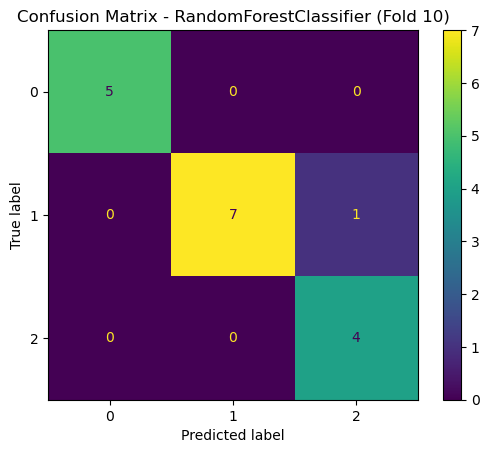


----------------------
Average validation F1 score: 0.975307332594352
Average test F1 score: 0.9826780626780627


In [14]:
clf = RandomForestClassifier(random_state=120, n_jobs=3)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__ccp_alpha'] = Categorical(ccp_alphas)
search_space['classification__class_weight'] = Categorical(['balanced','balanced_subsample',None])
nested_cv(X, y, pipeline, search_space)

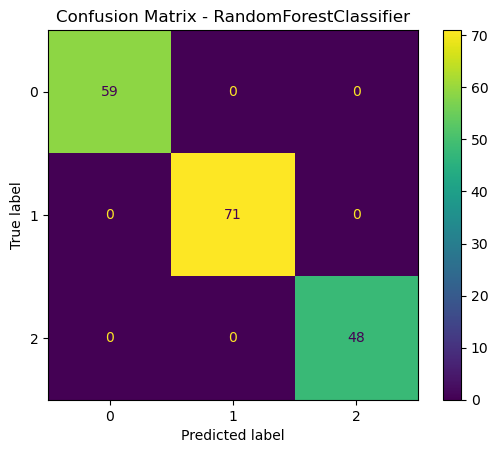

In [15]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - RandomForestClassifier")
plt.grid(False)
plt.show()

In [16]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - ExtraTreesClassifier (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.9768721804511278
Best hyperparameters for fold 1: OrderedDict([('classification__ccp_alpha', 0.009363295880149813), ('classification__class_weight', 'balanced_subsample')])
Test F1 score for fold 1: 0.9440559440559441



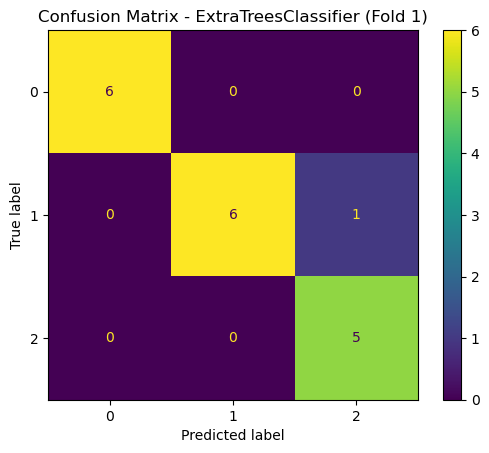


Validation F1 score for fold 2: 0.9690732115882204
Best hyperparameters for fold 2: OrderedDict([('classification__ccp_alpha', 0.06105020507820828), ('classification__class_weight', None)])
Test F1 score for fold 2: 1.0



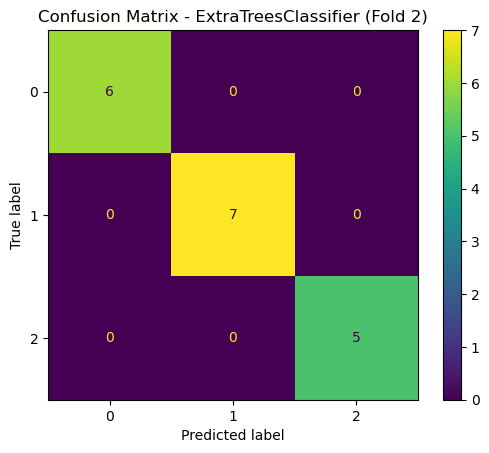


Validation F1 score for fold 3: 0.9885935127674259
Best hyperparameters for fold 3: OrderedDict([('classification__ccp_alpha', 0.010955056179775272), ('classification__class_weight', 'balanced_subsample')])
Test F1 score for fold 3: 0.9487179487179486



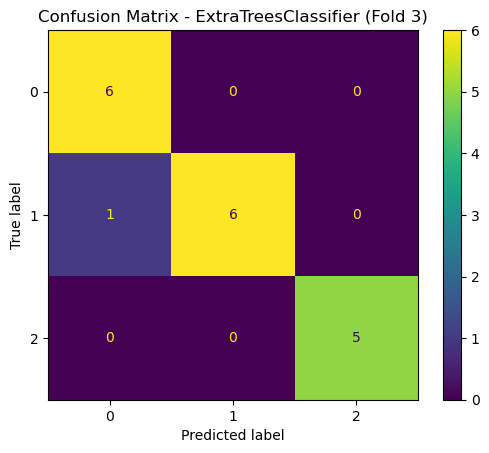


Validation F1 score for fold 4: 0.9876243250923558
Best hyperparameters for fold 4: OrderedDict([('classification__ccp_alpha', 0.009363295880149813), ('classification__class_weight', 'balanced_subsample')])
Test F1 score for fold 4: 1.0



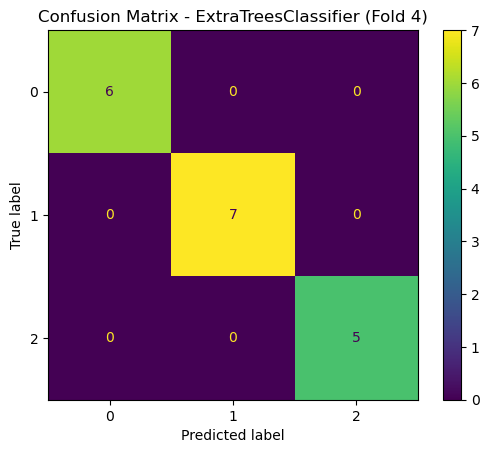


Validation F1 score for fold 5: 0.9759417854098162
Best hyperparameters for fold 5: OrderedDict([('classification__ccp_alpha', 0.0), ('classification__class_weight', None)])
Test F1 score for fold 5: 1.0



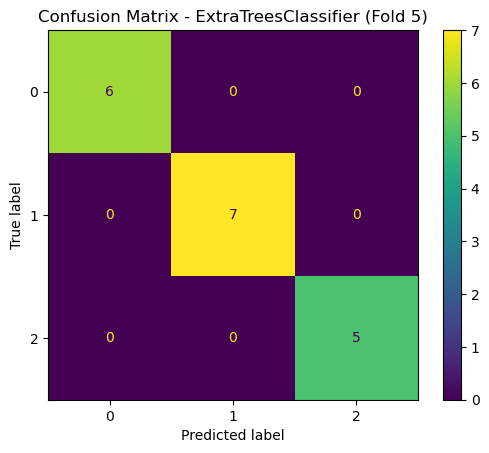


Validation F1 score for fold 6: 0.968234715803433
Best hyperparameters for fold 6: OrderedDict([('classification__ccp_alpha', 0.009363295880149813), ('classification__class_weight', None)])
Test F1 score for fold 6: 1.0



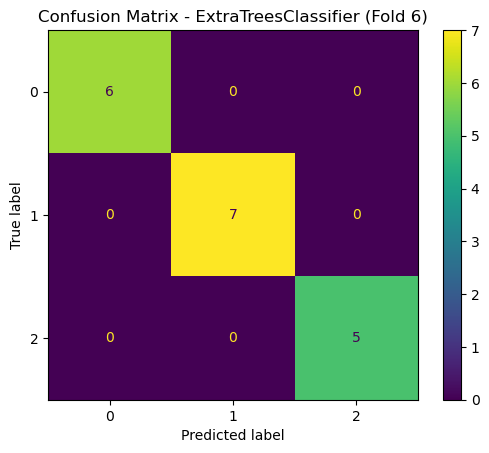


Validation F1 score for fold 7: 0.9632798259739527
Best hyperparameters for fold 7: OrderedDict([('classification__ccp_alpha', 0.010955056179775272), ('classification__class_weight', 'balanced')])
Test F1 score for fold 7: 1.0



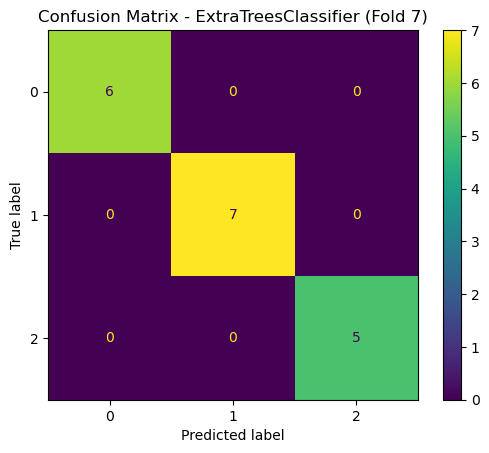


Validation F1 score for fold 8: 0.9688200922881229
Best hyperparameters for fold 8: OrderedDict([('classification__ccp_alpha', 0.010879258070269298), ('classification__class_weight', 'balanced')])
Test F1 score for fold 8: 0.9440559440559441



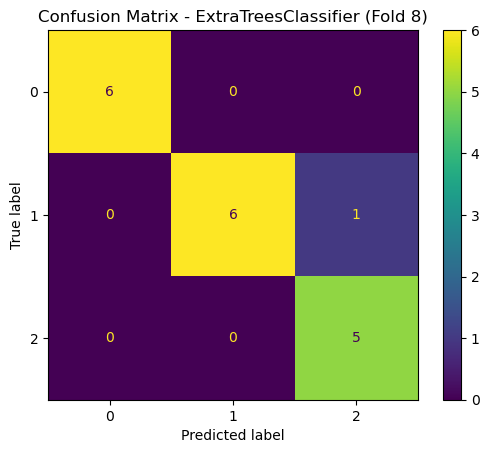


Validation F1 score for fold 9: 0.9698201770410682
Best hyperparameters for fold 9: OrderedDict([('classification__ccp_alpha', 0.016853932584269662), ('classification__class_weight', None)])
Test F1 score for fold 9: 0.9373219373219372



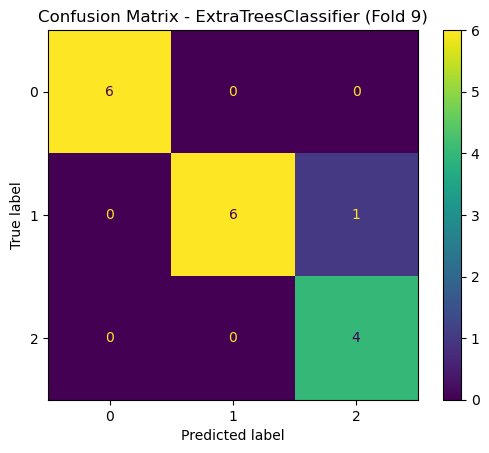


Validation F1 score for fold 10: 0.9887910436316233
Best hyperparameters for fold 10: OrderedDict([('classification__ccp_alpha', 0.009363295880149813), ('classification__class_weight', None)])
Test F1 score for fold 10: 0.9407407407407408



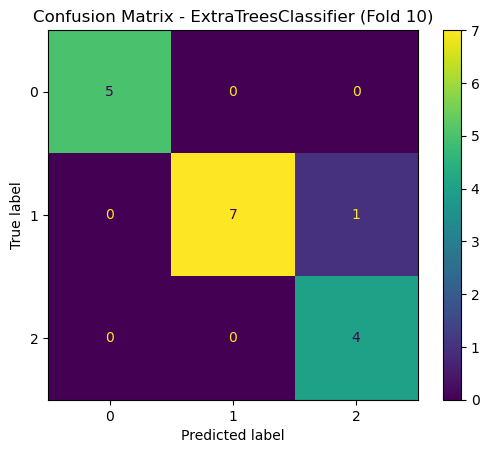


----------------------
Average validation F1 score: 0.9757050870047147
Average test F1 score: 0.9714892514892517


In [17]:
clf = ExtraTreesClassifier(random_state=120, n_jobs=3)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__ccp_alpha'] = Categorical(ccp_alphas)
search_space['classification__class_weight'] = Categorical(['balanced','balanced_subsample',None])
nested_cv(X, y, pipeline, search_space)

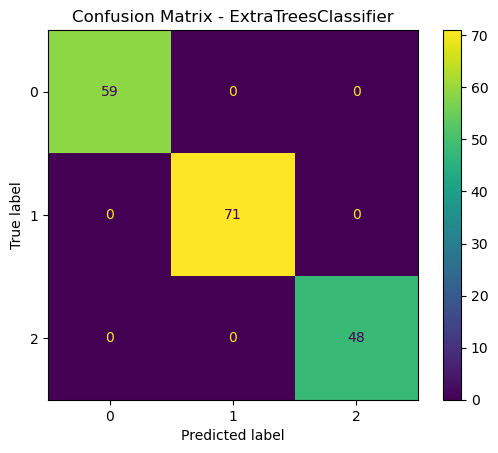

In [18]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - ExtraTreesClassifier")
plt.grid(False)
plt.show()